[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iabh1shekbasu/LungCancerDetectionEnsemble/blob/main/Probability_Extraction_and_Analysis.ipynb
)


## Connecting Google Drive

In [ ]:
# !pip install numpy==1.22.4 pandas==1.5.3 scipy==1.8.1

In [1]:
# prompt: check python version

!python --version


Python 3.10.14


In [ ]:
# !pip uninstall scikit-plot -y
# !pip install scikit-plot

In [ ]:
!sed -i 's/from scipy import interp/from numpy import interp/g' /opt/conda/lib/python3.10/site-packages/scikitplot/metrics.py


In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
import matplotlib.pyplot as plt
import math,os,argparse
# from scikitplot.estimators import plot_feature_importances
# from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

In [ ]:
# !mkdir /content/drive

In [ ]:
# from google.colab import drive
# # drive.mount('/content/drive')

In [4]:
# !google-drive-ocamlfuse
# !google-drive-ocamlfuse

!ls '/kaggle/input/ensemble-learning-on-lidc-dataset/data'

densenet169.h5	       resnet152_test.csv  train
densenet169_test.csv   test		   train_labels.csv
densenet169_train.csv  test_labels.csv	   val


In [ ]:
# !xdg-settings set default-web-browser w3m.desktop # to set default browser
# %cd /content
# !mkdir drive
# %cd drive
# !mkdir MyDrive
# %cd ..
# %cd ..
# !google-drive-ocamlfuse /content/drive/MyDrive

## Importing Libraries

This section imports necessary libraries required for the entire notebook. It includes deep learning libraries such as PyTorch, data manipulation libraries like NumPy, and visualization libraries such as matplotlib.

In [5]:
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import WeightedRandomSampler

## Data Preprocessing

This section defines the transformations to be applied to the input data for training and evaluation purposes. It includes normalization, resizing, and augmentation strategies.

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
       transforms.Resize((256,256)),
        transforms.ToTensor(),
    ]),
}

## Data Directory Setup

This sets the path to the directory where the dataset is stored. It's essential for the notebook to access the training and testing data.

In [17]:
!ls -la /kaggle/working/

total 12
drwxr-xr-x 3 root root 4096 Nov  4 13:21 .
drwxr-xr-x 5 root root 4096 Nov  4 13:21 ..
drwxr-xr-x 2 root root 4096 Nov  4 13:21 .virtual_documents


In [19]:
!mkdir /kaggle/working/saved/

In [20]:
!ls -la /kaggle/working

total 16
drwxr-xr-x 4 root root 4096 Nov  4 13:36 .
drwxr-xr-x 5 root root 4096 Nov  4 13:21 ..
drwxr-xr-x 2 root root 4096 Nov  4 13:21 .virtual_documents
drwxr-xr-x 2 root root 4096 Nov  4 13:36 saved


In [28]:
# data_dir = "/content/drive/MyDrive/Ensemble Learning on LIDC Dataset/data"  # Set the directory for the data
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in [ 'test', 'train', 'val']}
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
#                                              shuffle=True, num_workers=2)
#               for x in ['train', 'val','test']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['test', 'train', 'val']}
# class_names = image_datasets['train'].classes
# num_classes = len(class_names)
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(class_names)
# Set the path to the data directory

data_dir = "/kaggle/input/ensemble-learning-on-lidc-dataset/data"
save_dir = "/kaggle/working/saved"


# Verify the contents of the data directory
print("Contents of data directory:")
!ls "{data_dir}"

# Load the datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]),
}

# Define the datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Display the class names
print("Classes:", class_names)


Contents of data directory:
densenet169.h5	       resnet152_test.csv  train
densenet169_test.csv   test		   train_labels.csv
densenet169_train.csv  test_labels.csv	   val
Classes: ['benign', 'malignant']


## Visualization Function

Here we define a function to visualize images in the dataset. It will help in understanding the data and debugging the data loaders.

In [29]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

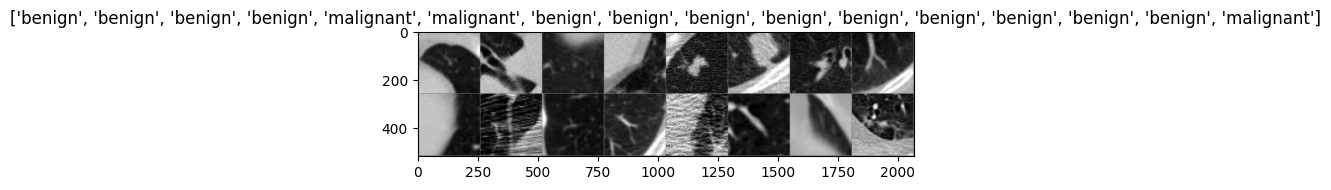

In [30]:
# Get a batch of testing data
inputs, classes = next(iter(dataloaders['test']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [31]:
def plot(val_loss,train_loss,typ):
    plt.title("{} after epoch: {}".format(typ,len(train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel(typ)
    plt.plot(list(range(len(train_loss))),train_loss,color="r",label="Train "+typ)
    plt.plot(list(range(len(val_loss))),val_loss,color="b",label="Validation "+typ)
    plt.legend()
    plt.savefig(os.path.join(data_dir,typ+".png"))
    plt.close()

In [32]:
val_loss_gph=[]
train_loss_gph=[]
val_acc_gph=[]
train_acc_gph=[]

## Model Training Function

This function encapsulates the model training logic. It takes a model, criterion for loss calculation, optimizer for backpropagation, and a scheduler for learning rate adjustment as inputs and conducts the training process.

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25,model_name = "kaggle"):

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        print('-' * 10)

        # Each epoch has a training and validation phase

        for phase in ['train', 'val']:

            if phase == 'train':

                model.train()  # Set model to training mode

            else:

                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            running_corrects = 0

            # Iterate over data.

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)

                labels = labels.to(device)

                # forward

                # track history if only in train

                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1) #was (outputs,1) for non-inception and (outputs.data,1) for inception

                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase

                    if phase == 'train':

                        optimizer.zero_grad()

                        loss.backward()

                        optimizer.step()

                # statistics

                running_loss += loss.item() * inputs.size(0)

                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':

                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':

              train_loss_gph.append(epoch_loss)

              train_acc_gph.append(epoch_acc)

            if phase == 'val':

              val_loss_gph.append(epoch_loss)

              val_acc_gph.append(epoch_acc)

           # plot(val_loss_gph,train_loss_gph, "Loss")

          #  plot(val_acc_gph,train_acc_gph, "Accuracy")

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(

                phase, epoch_loss, epoch_acc))

            # deep copy the model

            if phase == 'val' and epoch_acc >= best_acc:

                best_acc = epoch_acc

                best_model_wts = copy.deepcopy(model.state_dict())

                torch.save(model, save_dir+"/"+model_name+".pth")

                print('==>Model Saved')

        print()

    time_elapsed = time.time() - since

    print('Training complete in {:.0f}m {:.0f}s'.format(

        time_elapsed // 60, time_elapsed % 60))

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights

    model.load_state_dict(best_model_wts)

    return model


# ResNet 152

## Model Definition and Training

This section covers the instantiation of the ResNet152 model and its subsequent training with the dataset.

In [34]:
model = models.resnet152(pretrained = True)
#num_ftrs = model.classifier[0].in_features
num_ftrs = model.fc.in_features  ##for googlenet, resnet18
#num_ftrs = model.classifier.in_features  ## for densenet169
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "resnet152")

Number of features: 2048
Epoch 1/10
----------
train Loss: 0.3991 Acc: 0.8485
val Loss: 0.2471 Acc: 0.8728
==>Model Saved

Epoch 2/10
----------
train Loss: 0.2392 Acc: 0.9221
val Loss: 0.2802 Acc: 0.9260
==>Model Saved

Epoch 3/10
----------
train Loss: 0.1920 Acc: 0.9333
val Loss: 0.1770 Acc: 0.9453
==>Model Saved

Epoch 4/10
----------
train Loss: 0.1294 Acc: 0.9612
val Loss: 0.2255 Acc: 0.9306

Epoch 5/10
----------
train Loss: 0.1210 Acc: 0.9641
val Loss: 0.2706 Acc: 0.8967

Epoch 6/10
----------
train Loss: 0.0898 Acc: 0.9690
val Loss: 0.3122 Acc: 0.9399

Epoch 7/10
----------
train Loss: 0.0905 Acc: 0.9684
val Loss: 0.4136 Acc: 0.9406

Epoch 8/10
----------
train Loss: 0.0772 Acc: 0.9740
val Loss: 0.4149 Acc: 0.9098

Epoch 9/10
----------
train Loss: 0.1319 Acc: 0.9549
val Loss: 0.2280 Acc: 0.9522
==>Model Saved

Epoch 10/10
----------
train Loss: 0.0377 Acc: 0.9882
val Loss: 0.4710 Acc: 0.9160

Training complete in 26m 24s
Best val Acc: 0.952197


In [35]:
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()
import csv
import numpy as np  # Importing NumPy for numerical operations


Getting the Probability Distribution


In [38]:
f = open(save_dir+"/resnet152_train.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(trainloader),num_classes))

      for i,data in enumerate(trainloader):

          images, labels = data

          sample_fname, _ = trainloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Train Accuracy = ",100*correct/total)

for i in range(len(trainloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/train_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(trainloader):

  _, labels = data

  sample_fname, _ = trainloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Train Accuracy =  99.03605166763062


In [39]:
#Test Probabilities

f = open(save_dir+"/resnet152_test.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(testloader),num_classes))

      for i,data in enumerate(testloader):

          images, labels = data

          sample_fname, _ = testloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Test Accuracy = ",100*correct/total)

for i in range(len(testloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/test_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(testloader):

  _, labels = data

  sample_fname, _ = testloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Test Accuracy =  94.20468557336622


# Inception V3

## Inception V3 Model

Following the pattern of the previous section, this part focuses on the Inception V3 model, its setup, and training.

In [40]:

from torchvision import transforms



data_transforms = {

    'train': transforms.Compose([

        transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'val': transforms.Compose([

        transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'test': transforms.Compose([

        transforms.Resize((299, 299)),  # Resize images to 299x299 for Inception v3

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

}


In [41]:
import csv
import numpy as np
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()


Getting the Probability Distribution


In [42]:
f = open(save_dir+"/inception_v3_train.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(trainloader),num_classes))

      for i,data in enumerate(trainloader):

          images, labels = data

          sample_fname, _ = trainloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Train Accuracy = ",100*correct/total)

for i in range(len(trainloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/train_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(trainloader):

  _, labels = data

  sample_fname, _ = trainloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Train Accuracy =  99.03605166763062


In [43]:
#Test Probabilities

f = open(save_dir+"/inception_v3_test.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(testloader),num_classes))

      for i,data in enumerate(testloader):

          images, labels = data

          sample_fname, _ = testloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Test Accuracy = ",100*correct/total)

for i in range(len(testloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/test_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(testloader):

  _, labels = data

  sample_fname, _ = testloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Test Accuracy =  94.20468557336622


# Densenet 169



## Densenet 169  Model

Following the pattern of the previous section, this part focuses on the Densenet 169 model, its setup, and training.

In [44]:
model = models.densenet169(pretrained = True)
#num_ftrs = model.classifier[0].in_features
#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
num_ftrs = model.classifier.in_features  ## for densenet169
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "densenet169")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 61.5MB/s]


Number of features: 1664
Epoch 1/10
----------
train Loss: 0.3737 Acc: 0.8485
val Loss: 0.1776 Acc: 0.9553
==>Model Saved

Epoch 2/10
----------
train Loss: 0.1785 Acc: 0.9372
val Loss: 0.2581 Acc: 0.8967

Epoch 3/10
----------
train Loss: 0.1158 Acc: 0.9626
val Loss: 0.2115 Acc: 0.9399

Epoch 4/10
----------
train Loss: 0.0851 Acc: 0.9693
val Loss: 0.2221 Acc: 0.9468

Epoch 5/10
----------
train Loss: 0.0744 Acc: 0.9732
val Loss: 0.2529 Acc: 0.9584
==>Model Saved

Epoch 6/10
----------
train Loss: 0.0631 Acc: 0.9794
val Loss: 0.2444 Acc: 0.9375

Epoch 7/10
----------
train Loss: 0.0448 Acc: 0.9861
val Loss: 0.3743 Acc: 0.9591
==>Model Saved

Epoch 8/10
----------
train Loss: 0.0927 Acc: 0.9678
val Loss: 0.3158 Acc: 0.9437

Epoch 9/10
----------
train Loss: 0.0444 Acc: 0.9834
val Loss: 0.2283 Acc: 0.9614
==>Model Saved

Epoch 10/10
----------
train Loss: 0.0601 Acc: 0.9813
val Loss: 0.2671 Acc: 0.9453

Training complete in 14m 33s
Best val Acc: 0.961449


In [45]:
import csv
import numpy as np

# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()



Getting the Probability Distribution


In [46]:
f = open(save_dir+"/densenet169_train.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(trainloader),num_classes))

      for i,data in enumerate(trainloader):

          images, labels = data

          sample_fname, _ = trainloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Train Accuracy = ",100*correct/total)

for i in range(len(trainloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/train_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(trainloader):

  _, labels = data

  sample_fname, _ = trainloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()


Train Accuracy =  99.59514170040485


In [47]:
#Test Probabilities

f = open(save_dir+"/densenet169_test.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(testloader),num_classes))

      for i,data in enumerate(testloader):

          images, labels = data

          sample_fname, _ = testloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Test Accuracy = ",100*correct/total)

for i in range(len(testloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/test_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(testloader):

  _, labels = data

  sample_fname, _ = testloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Test Accuracy =  95.99260172626387


# Efficientnet B7 Model

## Efficientnet B7 Model

Following the pattern of the previous section, this part focuses on the Efficientnet B7 model, its setup, and training.

In [48]:
model = models.efficientnet_b7(pretrained = True)
#num_ftrs = model.classifier[0].in_features
#num_ftrs = model.fc.in_features  ##for googlenet, resnet18
#num_ftrs = model.classifier.in_features  ## for densenet169
num_ftrs = model.classifier[1].in_features   ## for efficientnet_b7
print("Number of features: "+str(num_ftrs))
#model.classifier = nn.Linear(num_ftrs, num_classes) ## for vgg19
#model.fc = nn.Linear(num_ftrs, num_classes)  ##for googlenet, resnet18
model.classifier = nn.Linear(num_ftrs, num_classes) ## for densenet169, efficientnet_b7
model = model.to(device)
criterion = nn.CrossEntropyLoss( weight = torch.tensor([1, 4.7]).to(device))
# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma=0.1)
model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=10, model_name = "efficientnet_b7")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 193MB/s]  


Number of features: 2560
Epoch 1/10
----------
train Loss: 0.3493 Acc: 0.8558
val Loss: 0.2471 Acc: 0.9167
==>Model Saved

Epoch 2/10
----------
train Loss: 0.1085 Acc: 0.9647
val Loss: 0.2558 Acc: 0.9460
==>Model Saved

Epoch 3/10
----------
train Loss: 0.0534 Acc: 0.9830
val Loss: 0.1685 Acc: 0.9453

Epoch 4/10
----------
train Loss: 0.0467 Acc: 0.9853
val Loss: 0.1980 Acc: 0.9630
==>Model Saved

Epoch 5/10
----------
train Loss: 0.0249 Acc: 0.9929
val Loss: 0.2311 Acc: 0.9684
==>Model Saved

Epoch 6/10
----------
train Loss: 0.0127 Acc: 0.9967
val Loss: 0.2081 Acc: 0.9499

Epoch 7/10
----------
train Loss: 0.0259 Acc: 0.9923
val Loss: 0.3487 Acc: 0.9545

Epoch 8/10
----------
train Loss: 0.0146 Acc: 0.9956
val Loss: 0.3376 Acc: 0.9630

Epoch 9/10
----------
train Loss: 0.0286 Acc: 0.9898
val Loss: 0.3579 Acc: 0.9561

Epoch 10/10
----------
train Loss: 0.0180 Acc: 0.9950
val Loss: 0.2059 Acc: 0.9561

Training complete in 40m 47s
Best val Acc: 0.968389


In [72]:
import csv
import numpy as np
# Getting Proba distribution
print("\nGetting the Probability Distribution")
trainloader=torch.utils.data.DataLoader(image_datasets['train'],batch_size=1)
testloader=torch.utils.data.DataLoader(image_datasets['test'],batch_size=1)
model=model.eval()


Getting the Probability Distribution


In [79]:
f = open(save_dir+"/efficientnetb7_train.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(trainloader),num_classes))

      for i,data in enumerate(trainloader):

          images, labels = data

          sample_fname, _ = trainloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Train Accuracy = ",100*correct/total)

for i in range(len(trainloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/train_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(trainloader):

  _, labels = data

  sample_fname, _ = trainloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()


Train Accuracy =  99.98072103335261


In [81]:
#Test Probabilities

f = open(save_dir+"/efficientnetb7_test.csv",'w+',newline = '')

writer = csv.writer(f)

saving = []

correct = 0

total = 0

with torch.no_grad():

      num = 0

      temp_array = np.zeros((len(testloader),num_classes))

      for i,data in enumerate(testloader):

          images, labels = data

          sample_fname, _ = testloader.dataset.samples[i]

          labels=labels.cuda()

          outputs = model(images.cuda())

          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)

          correct += (predicted == labels.cuda()).sum().item()

          prob = torch.nn.functional.softmax(outputs, dim=1)

          saving.append(sample_fname.split('/')[-1])

          temp_array[num] = np.asarray(prob[0].tolist()[0:num_classes])

          num+=1

print("Test Accuracy = ",100*correct/total)

for i in range(len(testloader)):

  k = temp_array[i].tolist()

  k.append(saving[i])

  writer.writerow(k)

f.close()

f = open(save_dir+"/test_labels.csv",'w+',newline = '')

writer = csv.writer(f)

for i,data in enumerate(testloader):

  _, labels = data

  sample_fname, _ = testloader.dataset.samples[i]

  sample = sample_fname.split('/')[-1]

  lab = labels.tolist()[0]

  writer.writerow([sample,lab])

f.close()



Test Accuracy =  97.04069050554871


# Ensemble Learning Analysis

## Imports

In [82]:
# !pip install scikit-plot

In [83]:
# !pip uninstall scipy -y

In [84]:
# !pip cache purge

In [85]:
# !pip install --force-reinstall numpy==1.22.4 scipy==1.8.1

In [86]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import *
# import matplotlib.pyplot as plt
# import math,os,argparse
# from scikitplot.estimators import plot_feature_importances
# from scikitplot.metrics import plot_confusion_matrix, plot_roc
# from sklearn.metrics import roc_curve,auc
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize

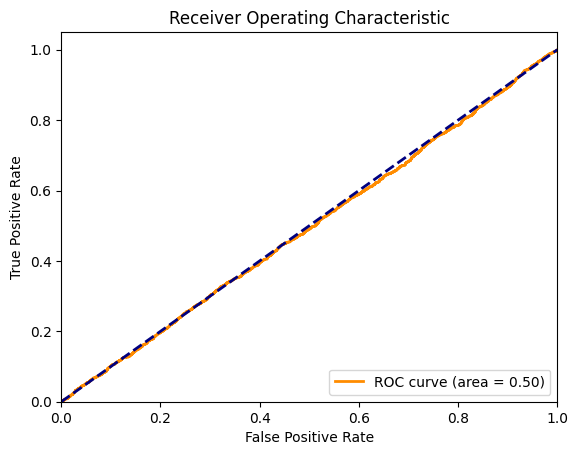

In [87]:
import argparse
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Initialize ArgumentParser
parser = argparse.ArgumentParser()

# Add arguments with default paths for notebook/testing in /kaggle/working/saved/
parser.add_argument('--root_dir', type=str, default='/kaggle/working/saved/', help='Directory where all files are stored')
parser.add_argument('--train_labels', type=str, default='/kaggle/working/saved/train_labels.csv', help='File path for train labels')
parser.add_argument('--test_labels', type=str, default='/kaggle/working/saved/test_labels.csv', help='File path for test labels')
parser.add_argument('--inception_v3_train', type=str, default='/kaggle/working/saved/inception_v3_train.csv', help='File path for inception v3 train data')
parser.add_argument('--inception_v3_test', type=str, default='/kaggle/working/saved/inception_v3_test.csv', help='File path for inception v3 test data')
parser.add_argument('--resnet152_train', type=str, default='/kaggle/working/saved/resnet152_train.csv', help='File path for resnet152 train data')
parser.add_argument('--resnet152_test', type=str, default='/kaggle/working/saved/resnet152_test.csv', help='File path for resnet152 test data')
parser.add_argument('--densenet169_train', type=str, default='/kaggle/working/saved/densenet169_train.csv', help='File path for densenet169 train data')
parser.add_argument('--densenet169_test', type=str, default='/kaggle/working/saved/densenet169_test.csv', help='File path for densenet169 test data')

# Parse arguments
args = parser.parse_args(args=[])

# Load train and test labels using paths from arguments
train_labels = pd.read_csv(args.train_labels, header=None)
test_labels = pd.read_csv(args.test_labels, header=None)

# Define test_labels and preds_original for the ROC plot
test_labels = test_labels[0].values  # Assuming labels are in the first column of test_df

# Example predictions (Replace this with actual model predictions)
# preds_original should be your model's predictions for the test set.
# Example placeholder for prediction probabilities; adjust according to your model's output
preds_original = np.random.rand(len(test_labels), np.unique(test_labels).shape[0])

# Example function to plot ROC curve (assuming binary classification)
def plot_roc_curve(test_labels, preds_original):
    # Binarize the labels if they are not already
    labels_bin = label_binarize(test_labels, classes=np.unique(test_labels))
    fpr, tpr, _ = roc_curve(labels_bin.ravel(), preds_original.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Call the plot function
plot_roc_curve(test_labels, preds_original)


## Data Loading

In [88]:
# import argparse
# import pandas as pd
# import numpy as np
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize

# # Initialize ArgumentParser
# parser = argparse.ArgumentParser()

# # Add arguments with default paths for notebook/testing
# parser.add_argument('--root_train', type=str, default='/kaggle/input/ensemble-learning-on-lidc-dataset/data/train', help='Directory where train csv files are stored')
# parser.add_argument('--train_labels', type=str, default='/kaggle/input/ensemble-learning-on-lidc-dataset/data/train_labels.csv', help='File path for train labels')
# parser.add_argument('--root_test', type=str, default='/kaggle/input/ensemble-learning-on-lidc-dataset/data/test', help='Directory where test csv files are stored')
# parser.add_argument('--test_labels', type=str, default='/kaggle/input/ensemble-learning-on-lidc-dataset/data/test_labels.csv', help='File path for test labels')

# # Parse arguments
# args = parser.parse_args(args=[])

# # Load train and test labels using paths from arguments
# train_df = pd.read_csv(args.train_labels, header=None)
# test_df = pd.read_csv(args.test_labels, header=None)

# # Define test_labels and preds_original for the ROC plot
# test_labels = test_df[0].values  # Assuming labels are in the first column of test_df
# # preds_original should be your model's predictions for the test set.
# # Replace this with your actual prediction array or DataFrame
# # Example placeholder: preds_original = model.predict_proba(test_data)

# # Example predictions (This should be replaced by your model predictions)
# # Assuming preds_original is in the format that matches test_labels
# preds_original = np.random.rand(len(test_labels), np.unique(test_labels).shape[0])  # Replace with actual predictions


In [89]:
# parser.add_argument('--root_train', type=str, required = True, help='Directory where train csv files are stored')
# parser.add_argument('--train_labels', type=str, required = True, help='File path for train labels')
# parser.add_argument('--root_test', type=str, required = True, help='Directory where test csv files are stored')
# parser.add_argument('--test_labels', type=str, required = True, help='File path for test labels')
# df = pd.read_csv(file,header=None)
# df = pd.read_csv(file,header=None)

## Helper Functions

In [77]:
# def predicting(ensemble_prob):
#     prediction = np.zeros((ensemble_prob.shape[0],))
#     for i in range(ensemble_prob.shape[0]):
#         temp = ensemble_prob[i]
#         t = np.where(temp == np.max(temp))[0][0]
#         prediction[i] = t
#     return prediction

# def getfile(filename):
#     root="./"
#     file = root+filename
#     if '.csv' not in file:
#         file+='.csv'
#     df = pd.read_csv(file,header=None)
#     df = np.asarray(df)[:,:-1] #Since last column has image names
#     return df

# def metrics(labels,predictions,classes):
#     print("Classification Report:")
#     print(classification_report(labels, predictions, target_names = classes,digits = 4))
#     matrix = confusion_matrix(labels, predictions)
#     accuracy = accuracy_score(labels,predictions)
#     pre = precision_score(labels,predictions)
#     rec = recall_score(labels,predictions)
#     f1 = f1_score(labels,predictions)
#     auc = roc_auc_score(labels,predictions)
#     print("Accuracy", accuracy)
#     print("Precision Score", pre)
#     print("Recall Score", rec)
#     print("F1 Score", f1)
#     print("Roc_Auc Score", auc)
#     print("Confusion matrix:")
#     print(matrix)
#     print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))

#======================

import numpy as np
import pandas as pd
import os
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Predicting function: Determines the class with the highest probability
def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        prediction[i] = np.argmax(ensemble_prob[i])  # Use np.argmax for simplicity
    return prediction

# File loading function with error handling and flexible path construction
def getfile(filename, root="./"):
    file_path = os.path.join(root, filename if filename.endswith('.csv') else f"{filename}.csv")
    try:
        df = pd.read_csv(file_path, header=None)
        df = np.asarray(df)[:, :-1]  # Assuming the last column contains image names
        return df
    except FileNotFoundError:
        print(f"File '{file_path}' not found.")
        return None

# Metrics calculation function with multi-class support and error handling
def metrics(labels, predictions, classes):
    print("Classification Report:")
    print(classification_report(labels, predictions, target_names=classes, digits=4))

    # Calculate confusion matrix and various scores
    matrix = confusion_matrix(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    pre = precision_score(labels, predictions, average="weighted")  # Multi-class support
    rec = recall_score(labels, predictions, average="weighted")      # Multi-class support
    f1 = f1_score(labels, predictions, average="weighted")           # Multi-class support

    # Attempt to calculate AUC, with handling for cases where AUC isn't feasible
    try:
        auc = roc_auc_score(labels, predictions, multi_class="ovr")  # Multi-class support
    except ValueError:
        auc = "N/A (AUC requires probability estimates for multi-class)"

    # Print results
    print("Accuracy:", accuracy)
    print("Precision Score:", pre)
    print("Recall Score:", rec)
    print("F1 Score:", f1)
    print("ROC AUC Score:", auc)
    print("Confusion Matrix:")
    print(matrix)

    # Calculate and display classwise accuracy
    classwise_accuracy = matrix.diagonal() / matrix.sum(axis=1)
    print("\nClasswise Accuracy: {}".format(classwise_accuracy))


# Plot ROC Curve Function

In [78]:

# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import label_binarize
# import numpy as np

# def plot_macro_average_roc(val_label, decision_val, caption='Macro-Average ROC Curve'):
#     num_classes = np.unique(val_label).shape[0]
#     classes = [i for i in range(num_classes)]
#     plt.figure()

#     # Ensure decision_val and val_label are binarized
#     if num_classes > 2:
#         y_val = label_binarize(val_label, classes=classes)
#         decision_val = label_binarize(decision_val, classes=classes) if decision_val.ndim == 1 else decision_val

#         # Calculate and plot macro-average ROC
#         fpr, tpr, all_fpr = dict(), dict(), np.unique(np.concatenate([roc_curve(y_val[:, i], decision_val[:, i])[0] for i in range(num_classes)]))
#         mean_tpr = np.zeros_like(all_fpr)

#         for i in range(num_classes):
#             fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
#             mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#         mean_tpr /= num_classes
#         macro_roc_auc = auc(all_fpr, mean_tpr)
#         plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC curve (AUC = {macro_roc_auc:.2f})', color='navy', linestyle='--')
#     else:
#         # For binary classification, use decision_val as a 1D array of positive class probabilities
#         if decision_val.ndim > 1 and decision_val.shape[1] == 2:
#             decision_val = decision_val[:, 1]  # Select probabilities for the positive class
#         fpr, tpr, _ = roc_curve(val_label, decision_val, pos_label=1)
#         roc_auc = auc(fpr, tpr) * 100
#         plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.2f})')

#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(caption)
#     plt.legend(loc="lower right")
#     plt.savefig(f"{num_classes}_class_macro_ROC.png", dpi=300)
#     plt.show()

# # Plot Macro-Average ROC curve using the function
# plot_macro_average_roc(test_labels, preds_original)


# Analysis


In [95]:
import argparse
import numpy as np
import pandas as pd
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# Define the argument parser with file paths
parser = argparse.ArgumentParser()
parser.add_argument('--root_dir', type=str, default='/kaggle/working/saved/', help='Directory where all files are stored')
parser.add_argument('--train_labels', type=str, default='/kaggle/working/saved/train_labels.csv', help='File path for train labels')
parser.add_argument('--test_labels', type=str, default='/kaggle/working/saved/test_labels.csv', help='File path for test labels')
parser.add_argument('--densenet169_train', type=str, default='/kaggle/working/saved/densenet169_train.csv', help='File path for densenet169 train data')
parser.add_argument('--efficientnetb7_train', type=str, default='/kaggle/working/saved/efficientnetb7_train.csv', help='File path for efficientnetb7 train data')
parser.add_argument('--resnet152_train', type=str, default='/kaggle/working/saved/resnet152_train.csv', help='File path for resnet152 train data')
parser.add_argument('--densenet169_test', type=str, default='/kaggle/working/saved/densenet169_test.csv', help='File path for densenet169 test data')
parser.add_argument('--efficientnetb7_test', type=str, default='/kaggle/working/saved/efficientnetb7_test.csv', help='File path for efficientnetb7 test data')
parser.add_argument('--resnet152_test', type=str, default='/kaggle/working/saved/resnet152_test.csv', help='File path for resnet152 test data')

# Parse arguments
args = parser.parse_args([])  # For notebook environments

# Function to load CSV files and exclude the last column (assuming it contains image names)
def getfile(file_path):
    df = pd.read_csv(file_path, header=None)
    return np.asarray(df)[:, :-1]  # Remove last column

# Load model predictions using parsed paths
p1_train = getfile(args.densenet169_train)
p2_train = getfile(args.efficientnetb7_train)
p3_train = getfile(args.resnet152_train)

# Specify the column index where the actual labels are stored
label_column = 1  # Modify this index based on the file structure

# Load labels, selecting the specified label column and converting to integers
train_labels = pd.read_csv(args.train_labels, header=None).iloc[:, label_column].astype(int).values
test_labels = pd.read_csv(args.test_labels, header=None).iloc[:, label_column].astype(int).values

p1_test = getfile(args.densenet169_test)
p2_test = getfile(args.efficientnetb7_test)
p3_test = getfile(args.resnet152_test)

# Confirm that the labels are now integer arrays
print("Sample Train Labels:", train_labels[:5])
print("Sample Test Labels:", test_labels[:5])

# Function to calculate scores and weights for models
def get_scores(labels, *models_predictions):
    num_models = len(models_predictions)
    metrics = np.zeros((2, num_models))
    num_classes = len(np.unique(labels))

    for i, model_preds in enumerate(models_predictions):
        preds = predicting(model_preds)

        if num_classes == 2:
            f1 = f1_score(labels, preds)
            auc = roc_auc_score(labels, preds)
        else:
            f1 = f1_score(labels, preds, average='macro')
            auc = roc_auc_score(labels, model_preds, average='macro', multi_class='ovo')

        metrics[:, i] = np.array([f1, auc])

    print("F1 Scores (per model):", metrics[0] * 100)
    print("ROC AUC Scores (per model):", metrics[1] * 100)

    weights = get_weights(np.transpose(metrics))
    return weights

# Weight calculation function using tanh transformation
def get_weights(matrix):
    weights = []
    for model_metrics in matrix:
        weight = np.sum(np.tanh(model_metrics))
        weights.append(weight)
    return weights

# Display header for training and test data metrics
print("=======================================================================")
print("                            Training Data Metrics")
print("=======================================================================")
weights = get_scores(train_labels, p1_train, p2_train, p3_train)

print("=======================================================================")
print("                             Testing Data Metrics")
print("=======================================================================")
weights = get_scores(test_labels, p1_test, p2_test, p3_test)

# Calculate ensemble probabilities using original weights
ensemble_prob_original = weights[0] * p1_test + weights[1] * p2_test + weights[2] * p3_test
preds_original = predicting(ensemble_prob_original)

# Normalize weights to sum up to 1 and calculate normalized ensemble probabilities
w0, w1, w2 = weights
total_weight = w0 + w1 + w2
w0_norm, w1_norm, w2_norm = w0 / total_weight, w1 / total_weight, w2 / total_weight
ensemble_prob_normalized = w0_norm * p1_test + w1_norm * p2_test + w2_norm * p3_test
preds_normalized = predicting(ensemble_prob_normalized)

# Display ensemble weights
print("=======================================================================")
print("                           Ensemble Weights")
print("=======================================================================")
print(f"Original Weights: {weights}")
print(f"Normalized Weights: {w0_norm:.4f}, {w1_norm:.4f}, {w2_norm:.4f}")

# Calculate adjusted weights for ensemble based on empirical findings
w0_adj, w1_adj, w2_adj = 0.3585864, 0.3441670, 0.2972466
ensemble_prob_adjusted = w0_adj * p1_test + w1_adj * p2_test + w2_adj * p3_test
preds_adjusted = predicting(ensemble_prob_adjusted)

# Function to calculate and display classification metrics
def metrics(labels, predictions, classes):
    print("=======================================================================")
    print("                           Classification Report")
    print("=======================================================================")
    print(classification_report(labels, predictions, target_names=classes, digits=4))

    matrix = confusion_matrix(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    pre = precision_score(labels, predictions, average="weighted")
    rec = recall_score(labels, predictions, average="weighted")
    f1 = f1_score(labels, predictions, average="weighted")
    try:
        auc = roc_auc_score(labels, predictions, multi_class="ovr")
    except ValueError:
        auc = "N/A (AUC requires probabilities for multi-class)"

    print("Accuracy:", accuracy)
    print("Precision Score:", pre)
    print("Recall Score:", rec)
    print("F1 Score:", f1)
    print("ROC AUC Score:", auc)
    print("Confusion Matrix:")
    print(matrix)
    print("\nClasswise Accuracy:", matrix.diagonal() / matrix.sum(axis=1))

# Display metrics for each ensemble method
print("\n=======================================================================")
print("                     Metrics with Original Weights")
print("=======================================================================")
metrics(test_labels, preds_original, classes=['Benign', 'Malignant'])

print("\n=======================================================================")
print("                     Metrics with Normalized Weights")
print("=======================================================================")
metrics(test_labels, preds_normalized, classes=['Benign', 'Malignant'])

print("\n=======================================================================")
print("                      Metrics with Adjusted Weights")
print("=======================================================================")
metrics(test_labels, preds_adjusted, classes=['Benign', 'Malignant'])


Sample Train Labels: [0 0 0 0 0]
Sample Test Labels: [0 0 0 0 0]
                            Training Data Metrics
F1 Scores (per model): [98.7654321  99.94079337 97.11981567]
ROC AUC Scores (per model): [99.51989512 99.9408284  99.32891613]
                             Testing Data Metrics
F1 Scores (per model): [88.69565217 91.51943463 84.33333333]
ROC AUC Scores (per model): [93.79485551 94.98914999 92.43278289]
                           Ensemble Weights
Original Weights: [1.444165540897293, 1.4633499763996585, 1.4155089510191736]
Normalized Weights: 0.3341, 0.3385, 0.3274

                     Metrics with Original Weights
                           Classification Report
              precision    recall  f1-score   support

      Benign     0.9835    0.9806    0.9821      1340
   Malignant     0.9091    0.9220    0.9155       282

    accuracy                         0.9704      1622
   macro avg     0.9463    0.9513    0.9488      1622
weighted avg     0.9706    0.9704    0.9705

In [ ]:
# # Function to calculate scores for each model
# def get_scores(labels, *models_predictions):
#     """
#     Calculates precision, recall, f1-score, and AUC for each model's predictions.

#     :param labels: The ground truth labels.
#     :param models_predictions: Variable number of arrays with model predictions.
#     :return: A list of weights for each set of model predictions.
#     """
#     num_models = len(models_predictions)
#     # Initialize metrics array
#     metrics = np.zeros((2, num_models))
#     num_classes = len(np.unique(labels))

#     for i, model_preds in enumerate(models_predictions):
#         # Simulate a predicting function for model predictions
#         preds = predicting(model_preds)

#         # Calculate different metrics depending on the number of classes
#         if num_classes == 2:  # Binary classification
#             pre = precision_score(labels, preds)
#             rec = recall_score(labels, preds)
#             f1 = f1_score(labels, preds)
#             auc = roc_auc_score(labels, preds)
#         else:  # Multiclass classification
#             pre = precision_score(labels, preds, average='macro')
#             rec = recall_score(labels, preds, average='macro')
#             f1 = f1_score(labels, preds, average='macro')
#             auc = roc_auc_score(labels, model_preds, average='macro', multi_class='ovo')

#         # Update metrics array with the calculated metrics
#         metrics[:, i] = np.array([f1, auc])

#     # Output the f1 and auc scores for each model
#     print("F1 Score", metrics[0] * 100)
#     print("ROC_AUC Score", metrics[1] * 100)

#     # Calculate weights based on the metrics
#     weights = get_weights(np.transpose(metrics))
#     return weights

# def get_weights(matrix):
#     """
#     Calculates weights for each model using the tanh function on the metrics.

#     :param matrix: A matrix of shape (number of models, number of metrics).
#     :return: A list of weights for each model.
#     """
#     weights = []
#     for model_metrics in matrix:
#         # Use tanh to compute a weighted sum of metrics for each model
#         weight = np.sum(np.tanh(model_metrics))
#         weights.append(weight)
#     return weights

# # Ensure the training root path ends with a slash
# root_train = args.root_train
# if root_train[-1] != '/':
#     root_train += '/'

# # Ensure the testing root path ends with a slash
# root_test = args.root_test
# if root_test[-1] != '/':
#     root_test += '/'

# # Define the filenames for the training predictions from different models
# train1 = "densenet169_train_adam"
# train2 = "efficientnetb7_train_adam"
# train3 = "resnet152_train_adam"

# # Retrieve the predictions from files for training data
# p1_train = getfile(root_train + train1)  # Get predictions for the first model
# p2_train = getfile(root_train + train2)  # Get predictions for the second model
# p3_train = getfile(root_train + train3)  # Get predictions for the third model

# # Load the labels for the training data
# train_labels = getlabels(args.train_labels)

# # Define the filenames for the testing predictions from different models
# test1 = "densenet169_test_adam"
# test2 = "efficientnetb7_test_adam"
# test3 = "resnet152_test_adam"

# # Retrieve the predictions from files for testing data
# p1_test = getfile(root_test + test1)  # Get predictions for the first model
# p2_test = getfile(root_test + test2)  # Get predictions for the second model
# p3_test = getfile(root_test + test3)  # Get predictions for the third model

# # Load the labels for the testing data
# test_labels = getlabels(args.test_labels)

# # Print the order of CSV files
# print("Train CSV's Order", train1 + ", " + train2 + ", " + train3)
# print("\n")
# print("Test CSV's Order", test1 + ", " + test2 + ", " + test3)
# print("\n")

# # Display header for training data metrics
# print("Training Data Metrics")
# print("--------------------------------------------------------------------------------------")
# print(train1 + " " + train2 + " " + train3)
# print("--------------------------------------------------------------------------------------")

# # Get weights based on training labels and predictions
# weights = get_scores(train_labels, p1_train, p2_train, p3_train)
# print("\n")

# # Display header for testing data metrics
# print("Testing Data Metrics")
# print("--------------------------------------------------------------------------------------")
# print(test1 + " " + test2 + " " + test3)
# print("--------------------------------------------------------------------------------------")
# weight = get_scores(test_labels, p1_test, p2_test, p3_test)
# print("\n")

# # Display original weights
# print("Original Weights")
# print("--------------------------------------------------------------------------------------")
# print(train1, weights[0])
# print(train2, weights[1])
# print(train3, weights[2])
# print("\n")

# # Calculate ensemble probabilities using the original weights
# ensemble_prob_original = weights[0] * p1_test + weights[1] * p2_test + weights[2] * p3_test

# # Display ensemble probabilities with original weights
# print("Ensemble Probabilities with Original Weights", ensemble_prob_original)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Generate predictions using the original ensemble probabilities
# preds_original = predicting(ensemble_prob_original)

# # Display predictions with original weights
# print("Predictions with Original Weights", preds_original)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Normalize the weights so they sum up to 1
# w0, w1, w2 = weights
# w0_norm = w0 / (w0 + w1 + w2)
# w1_norm = w1 / (w0 + w1 + w2)
# w2_norm = w2 / (w0 + w1 + w2)

# # Display normalized weights
# print("Normalised Weights")
# print("--------------------------------------------------------------------------------------")
# print(train1, w0_norm)
# print(train2, w1_norm)
# print(train3, w2_norm)
# print("\n")

# # Calculate ensemble probabilities using the normalized weights
# ensemble_prob_Normal = w0_norm * p1_test + w1_norm * p2_test + w2_norm * p3_test

# # Display ensemble probabilities with normalized weights
# print("Ensemble Probabilities with Normal Weights", ensemble_prob_Normal)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Generate predictions using the normalized ensemble probabilities
# preds_Normal = predicting(ensemble_prob_Normal)

# # Display predictions with normalized weights
# print("Predictions with Normal Weights", preds_Normal)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Manually adjusted weights based on empirical findings
# w0_adj = 0.3585864 # Best Weights for some criterion
# w1_adj = 0.3441670 # Best Weights for some criterion
# w2_adj = 0.2972466 # Best Weights for some criterion

# # Display adjusted weights
# print("Adjusted Weights")
# print("--------------------------------------------------------------------------------------")
# print(train1, w0_adj)
# print(train2, w1_adj)
# print(train3, w2_adj)
# print("\n")

# # Calculate ensemble probabilities using the adjusted weights
# ensemble_prob_Adjusted = w0_adj * p1_test + w1_adj * p2_test + w2_adj * p3_test

# # Display ensemble probabilities after updating weights
# print("Ensemble Probabilities After Updating Weights", ensemble_prob_Adjusted)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Generate predictions using the adjusted ensemble probabilities
# preds_Adjusted = predicting(ensemble_prob_Adjusted)

# # Display predictions after updating weights
# print("Predictions After Updating Weights", preds_Adjusted)
# print("--------------------------------------------------------------------------------------")
# print("\n")

# # Calculate the number of correct predictions with original weights and print accuracy
# correct_original = np.where(preds_original == test_labels)[0].shape[0]
# total = test_labels.shape[0]
# print("\n")
# print("Accuracy (Original) = ", (correct_original / total) * 100)
# print("\n")

# # Print classification metrics for the predictions made with original weights
# classes = ['Benign', 'Malignant']
# metrics(test_labels, preds_original, classes)

# # Calculate the number of correct predictions with normalized weights and print accuracy
# correct_Normal = np.where(preds_Normal == test_labels)[0].shape[0]
# print("\n")
# print("Accuracy (Normal) = ", (correct_Normal / total) * 100)
# print("\n")

# # Print classification metrics for the predictions made with normalized weights
# metrics(test_labels, preds_Normal, classes)